# TTT4185 Machine learning for Speech technology

## Computer assigment 3a: Classification using Deep Neural Networks

This assignment assumes that the student has reviewed the material on deep neural networks.

In this assignment we will use the high level `Keras` framework together with `Tensorflow` to perform some deep learning experiments.

We will be using a small database of phonemes, where each phoneme is represented by the four first formant positions ("F1"-"F4") and their corresponding bandwidths ("B1"-"B4"). All numbers are in kHz. In addition, the speaker ID and the gender of the speaker are given for each phoneme.

The first few cells of this notebook contain example code to load and extract data, setup a simple network and train a deep neural network for classification. 

Note that we do not have a test dataset, but only training and validation sets. We do some experiments on the training set and observe the effect on the validation set.

In [1]:
!pip install -U scikit-learn

In [2]:
!pip install tensorflow

  Using cached clang-5.0.tar.gz (30 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for clang: filename=clang-5.0-py3-none-any.whl size=30701 sha256=7e2bae7e24584eb339ad48a8843c298eb546dc1c11a5e50093da06c58a1cb3e3
  Stored in directory: c:\users\sebsk\appdata\local\pip\cache\wheels\3a\ce\7a\27094f689461801c934296d07078773603663dfcaca63bb064
Successfully built clang


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# %matplotlib inline

import tensorflow as tf
from tensorflow import keras

In [4]:
# Load data from CSV files 
rawtrain = pd.read_csv("Train.csv")
rawvalid = pd.read_csv("Validation.csv")

# Take a peek at the raw data
rawtrain.head(10)

,SpeakerID,Gender,Phoneme,F1,F2,F3,F4,B1,B2,B3,B4
0,cjf0,F,h#,0.701982,2.125440,2.433528,3.530050,0.264459,0.326273,0.300301,0.410096
1,cjf0,F,q,0.340942,2.594934,2.788244,4.028250,0.282159,0.471724,0.310578,0.505835
2,cjf0,F,iy,0.487078,2.605132,3.093409,4.354061,0.174520,0.340025,0.232818,0.413965
3,cjf0,F,v,0.505536,2.034326,2.804329,4.130655,0.190478,0.307295,0.301741,0.370238
4,cjf0,F,ih,0.524527,2.055382,2.989248,4.480000,0.164466,0.312337,0.301859,0.362134
5,cjf0,F,n,0.601591,2.046562,3.251497,4.561420,0.185757,0.334235,0.316704,0.381524
6,cjf0,F,eh,0.762154,2.127740,3.212496,4.412842,0.207840,0.303633,0.285026,0.384152
7,cjf0,F,n,0.714553,1.837149,3.218620,5.001730,0.252105,0.311876,0.333318,0.432281
8,cjf0,F,q,0.619766,2.276717,3.109751,4.658425,0.231525,0.314789,0.406002,0.417538
9,cjf0,F,ix,0.463761,2.181577,2.859900,4.327639,0.170244,0.319690,0.291556,0.425367


In [5]:
# We will be classifying three different vowels. Extract the training and validation data
phonemes = ["ae", "ey", "ux"]
train = rawtrain[rawtrain["Phoneme"].isin(phonemes)]
valid = rawvalid[rawvalid["Phoneme"].isin(phonemes)]
trainlabels = [phonemes.index(ph) for ph in train["Phoneme"]]
validlabels = [phonemes.index(ph) for ph in valid["Phoneme"]]

In [6]:
# Features to use
features_F1toF2 = ["F1","F2"]

# def format_dataset(features):

#     # Extract features
#     x_train_raw = train[features]
#     x_valid_raw = valid[features]

#     # Normalize to zero mean
#     x_mean = np.mean(x_train_raw)
#     x_std = np.std(x_train_raw)
#     x_train = x_train_raw - x_mean
#     x_valid = x_valid_raw - x_mean

#     # Fix labels. The "to_categorical" call maps integer labels {n}
#     # to a vector of length N (number of labels) with a one in position n
#     y_train = keras.utils.to_categorical(trainlabels, len(phonemes))
#     y_valid = keras.utils.to_categorical(validlabels, len(phonemes))

#     # dataset = 

#     return {"x_train": x_train, "y_train": y_train, "x_valid": x_valid, "y_valid": y_valid}

# dataset_F1toF2 = format_dataset(features)

# print(dataset_F1toF2)

In [7]:
class PhonemesDataset:
    # initilize model based on given features
    def __init__(self, features, name='model'):
        self.name = name
        # Extract features
        x_train_raw = train[features]
        x_valid_raw = valid[features]

        # Normalize to zero mean
        x_mean = np.mean(x_train_raw)
        x_std = np.std(x_train_raw)
        self.x_train = x_train_raw - x_mean
        self.x_valid = x_valid_raw - x_mean

        # Fix labels. The "to_categorical" call maps integer labels {n}
        # to a vector of length N (number of labels) with a one in position n
        self.y_train = keras.utils.to_categorical(trainlabels, len(phonemes))
        self.y_valid = keras.utils.to_categorical(validlabels, len(phonemes))

    # Create a model with a single hidden layer
    def Create_and_train_SHL_model(self):
        self.model = keras.Sequential([
            keras.layers.Dense(256, activation=tf.nn.relu,
                               input_dim=self.x_train.shape[1]),
            keras.layers.Dense(len(phonemes), activation=tf.nn.softmax)
        ])

        self.model.summary()

        # Train the model
        self.model.compile(loss='categorical_crossentropy',
                           optimizer='adam',
                           metrics=['accuracy'])

        # Train the model
        self.history = self.model.fit(self.x_train, self.y_train, validation_data=(self.x_valid, self.y_valid),
                                      epochs=1000, batch_size=32, verbose=True)
        self.model.save('models/model_'+self.name)

    # Visualize the training results
    def Visualize(self):
        if (keras.models.load_model('models/model_'+self.name)):
            plt.figure(figsize=(10, 8))
            plt.plot(self.history.history['loss'], label='loss')
            plt.plot(self.history.history['accuracy'], label='acc')
            plt.plot(self.history.history['val_loss'], label='val_loss')
            plt.plot(self.history.history['val_accuracy'], label='val_acc')
            plt.grid()
            plt.title(self.name)
            plt.legend()
            plt.show()
        else:
            print("No model intilized")

    

dataset_F1toF2 = PhonemesDataset(features_F1toF2, "F1toF2")


In [8]:
def Validate(dataset):
    # Validation model
    score = dataset_F1toF4.model.evaluate(dataset.x_valid, dataset.y_valid, verbose=0)
    print('Validation loss:', score[0])
    print('Validation accuracy:', score[1])

In [9]:
dataset_F1toF2.test = 2

In [10]:
dataset_F1toF2.Create_and_train_SHL_model()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               768       
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 771       
Total params: 1,539
Trainable params: 1,539
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
18/18 [==============================] - 1s 18ms/step - loss: 1.0627 - accuracy: 0.5827 - val_loss: 1.0350 - val_accuracy: 0.6347
Epoch 2/1000
18/18 [==============================] - 0s 3ms/step - loss: 0.9867 - accuracy: 0.6871 - val_loss: 0.9760 - val_accuracy: 0.6384
Epoch 3/1000
18/18 [==============================] - 0s 3ms/step - loss: 0.9145 - accuracy: 0.6763 - val_loss: 0.9235 - val_accuracy: 0.6199
Epoch 4/1000
18/18 [==============================] - 0s 3ms/step - loss: 0.8520 - accura

In [11]:
# Visualize the training results
dataset_F1toF2.Visualize()

In [ ]:
# Validation model
score = dataset_F1toF2.model.evaluate(dataset_F1toF2.x_valid, dataset_F1toF2.y_valid, verbose=0)
print('Validation loss:', score[0])
print('Validation accuracy:', score[1])

Error: Session cannot generate requests

## Problem 1
Increase the number of features to include "F3" and "F4" and rerun the experiments. Try also adding the bandwidths ("B1"-"B4").

Initilize dataset

In [ ]:
# print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

features_F1toF4 = ['F1', 'F2','F3','F4']

dataset_F1toF4 = Dataset(features_F1toF4, 'F1toF4')


Num GPUs Available:  0


Create model and train

In [ ]:
# Create a model with a single hidden layer
dataset_F1toF4.Create_and_train_SHL_model()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_22 (Dense)             (None, 256)               1280      
_________________________________________________________________
dense_23 (Dense)             (None, 3)                 771       
Total params: 2,051
Trainable params: 2,051
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
18/18 [==============================] - 0s 7ms/step - loss: 1.0554 - accuracy: 0.5576 - val_loss: 1.0358 - val_accuracy: 0.4982
Epoch 2/1000
18/18 [==============================] - 0s 1ms/step - loss: 0.9806 - accuracy: 0.6079 - val_loss: 0.9915 - val_accuracy: 0.5277
Epoch 3/1000
18/18 [==============================] - 0s 1ms/step - loss: 0.9206 - accuracy: 0.6241 - val_loss: 0.9562 - val_accuracy: 0.5572
Epoch 4/1000
18/18 [==============================] - 0s 1ms/step - loss: 0.8731 - accu

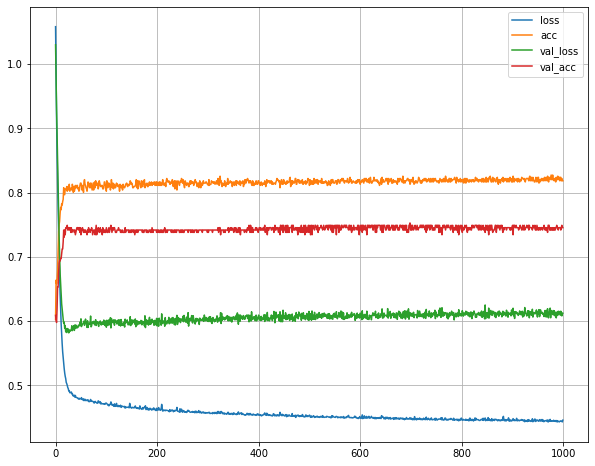

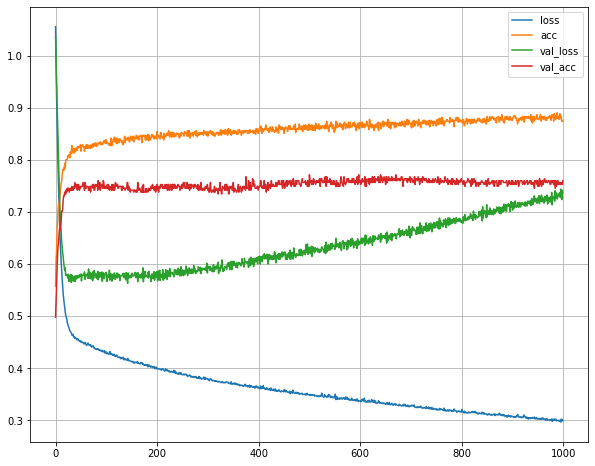

In [ ]:
dataset_F1toF2.Visualize()
dataset_F1toF4.Visualize()

In [ ]:
# Validation model
score = dataset_F1toF4.model.evaluate(dataset_F1toF4.x_valid, dataset_F1toF4.y_valid, verbose=0)
print('Validation loss:', score[0])
print('Validation accuracy:', score[1])

AttributeError: 'dataset' object has no attribute 'model'

#### B1 and B2

In [ ]:
features_F1toF4_B1toB4 = ['F1', 'F2','F3','F4', 'B1', 'B2', 'B3', 'B4']

dataset_F1toF4_B1toB4 = Dataset(features_F1toF4_B1toB4, 'F1toF4_B1toB4')

In [ ]:
# Create a model with a single hidden layer
dataset_F1toF4_B1toB4.Create_and_train_SHL_model()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_24 (Dense)             (None, 256)               2304      
_________________________________________________________________
dense_25 (Dense)             (None, 3)                 771       
Total params: 3,075
Trainable params: 3,075
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
18/18 [==============================] - 0s 7ms/step - loss: 1.0764 - accuracy: 0.4604 - val_loss: 1.0540 - val_accuracy: 0.4908
Epoch 2/1000
18/18 [==============================] - 0s 1ms/step - loss: 1.0016 - accuracy: 0.5540 - val_loss: 1.0128 - val_accuracy: 0.4834
Epoch 3/1000
18/18 [==============================] - 0s 1ms/step - loss: 0.9411 - accuracy: 0.5791 - val_loss: 0.9759 - val_accuracy: 0.5314
Epoch 4/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.8927 - accu

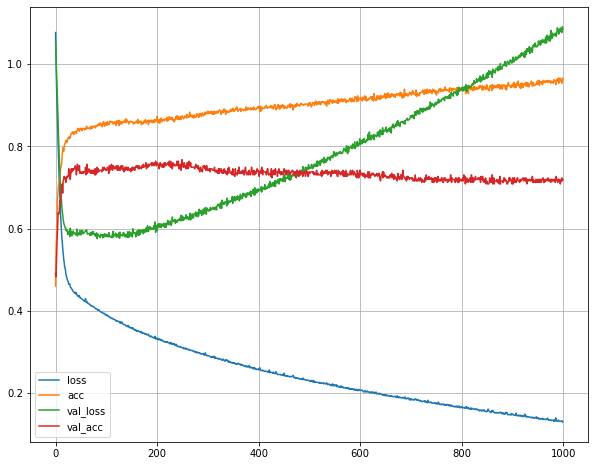

In [ ]:
dataset_F1toF4_B1toB4.Visualize()

In [ ]:
# Validation model
score = dataset_F1toF4_B1toB4.model.evaluate(dataset_F1toF4_B1toB4.x_valid, dataset_F1toF4_B1toB4.y_valid, verbose=0)
print('Validation loss:', score[0])
print('Validation accuracy:', score[1])

Validation loss: 1.0850657224655151
Validation accuracy: 0.7195571660995483


Comment: Seems to be overfitting

## Problem 2
Change the number of nodes in the hidden layer and see how the results change. Try using dropout, and observe the results.

In [ ]:

# Create a model with a single hidden layer
def Create_and_train_SHL_model_512(dataset):
    dataset.model = keras.Sequential([
        keras.layers.Dense(512, activation=tf.nn.relu,
                            input_dim=dataset.x_train.shape[1]),
        keras.layers.Dense(len(phonemes), activation=tf.nn.softmax)
    ])

    dataset.model.summary()

    # Train the model
    dataset.model.compile(loss='categorical_crossentropy',
                        optimizer='adam',
                        metrics=['accuracy'])

    # Train the model
    dataset.history = dataset.model.fit(dataset.x_train, dataset.y_train, validation_data=(dataset.x_valid, dataset.y_valid),
                                    epochs=1000, batch_size=32, verbose=True)
    dataset.model.save('models/model_'+dataset.name)


Create_and_train_SHL_model_512(dataset_F1toF4)

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_32 (Dense)             (None, 512)               4608      
_________________________________________________________________
dense_33 (Dense)             (None, 3)                 1539      
Total params: 6,147
Trainable params: 6,147
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
18/18 [==============================] - 0s 7ms/step - loss: 1.0341 - accuracy: 0.6475 - val_loss: 1.0039 - val_accuracy: 0.5609
Epoch 2/1000
18/18 [==============================] - 0s 1ms/step - loss: 0.9309 - accuracy: 0.6493 - val_loss: 0.9439 - val_accuracy: 0.5756
Epoch 3/1000
18/18 [==============================] - 0s 1ms/step - loss: 0.8545 - accuracy: 0.6709 - val_loss: 0.8840 - val_accuracy: 0.6236
Epoch 4/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.7912 - accu

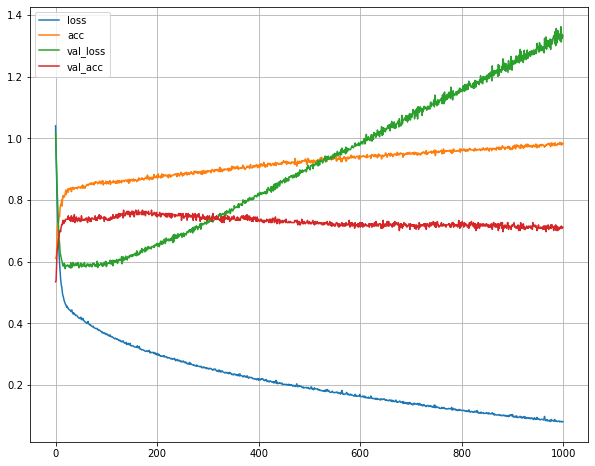

In [ ]:
dataset_F1toF4.Visualize()

In [ ]:
Validate(dataset_F1toF4)

Validation loss: 1.332657814025879
Validation accuracy: 0.7121770977973938


#### with drop

In [ ]:
# Create a model with a single hidden layer
def Create_and_train_SHL_model_512_dropout(dataset):
    dataset.model = keras.Sequential([
        keras.layers.Dense(512, activation=tf.nn.relu,
                            input_dim=dataset.x_train.shape[1]),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(len(phonemes), activation=tf.nn.softmax)
    ])

    dataset.model.summary()

    # Train the model
    dataset.model.compile(loss='categorical_crossentropy',
                        optimizer='adam',
                        metrics=['accuracy'])

    # Train the model
    dataset.history = dataset.model.fit(dataset.x_train, dataset.y_train, validation_data=(dataset.x_valid, dataset.y_valid),
                                    epochs=1000, batch_size=32, verbose=True)
    dataset.model.save('models/model_'+dataset.name)

Create_and_train_SHL_model_512_dropout(dataset_F1toF4_B1toB4)

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_52 (Dense)             (None, 512)               4608      
_________________________________________________________________
dropout_6 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_53 (Dense)             (None, 3)                 1539      
Total params: 6,147
Trainable params: 6,147
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
18/18 [==============================] - 0s 8ms/step - loss: 1.0433 - accuracy: 0.5683 - val_loss: 1.0210 - val_accuracy: 0.5314
Epoch 2/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.9511 - accuracy: 0.6313 - val_loss: 0.9648 - val_accuracy: 0.5941
Epoch 3/1000
18/18 [==============================] - 0s 2ms/step - loss: 0.8863 - accuracy: 0.64

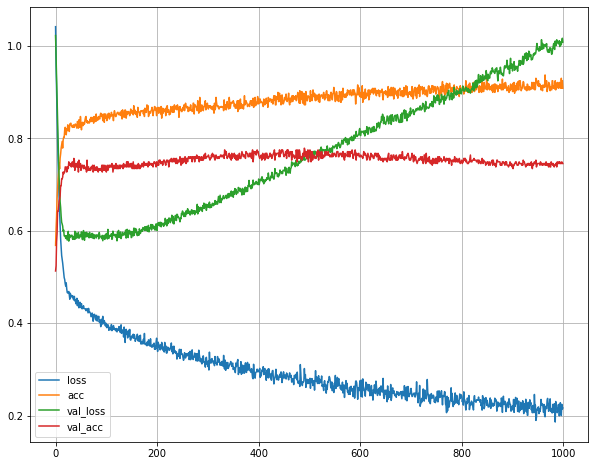

In [ ]:
dataset_F1toF4.Visualize()

In [ ]:
Validate(dataset_F1toF4)

Validation loss: 1.1566559076309204
Validation accuracy: 0.7343173623085022


In [ ]:
Validate(dataset_F1toF4_B1toB4)

Validation loss: 1.0578421354293823
Validation accuracy: 0.7158671617507935


In [ ]:
gpus = tf.config.list_physical_devices('GPU')

if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)

## Problem 3
Add multiple layers to the network and observe the results.

In [ ]:
# Create a model with a multi hidden layer
def Create_and_train_MHL_model_256_dropout(dataset):
    dataset.model = keras.Sequential([
        keras.layers.Dense(256, activation=tf.nn.relu, input_dim=dataset.x_train.shape[1]),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(16, activation=tf.nn.relu),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(len(phonemes), activation=tf.nn.softmax, name="pred", kernel_regularizer=keras.regularizers.l1_l2(l1=1e-5, l2=1e-4),)
    ])

    dataset.model.summary()

    # Train the model
    dataset.model.compile(loss='categorical_crossentropy',
                        optimizer='adam',
                        metrics=['accuracy'])

    # Train the model
    dataset.history = dataset.model.fit(dataset.x_train, dataset.y_train, validation_data=(dataset.x_valid, dataset.y_valid),
                                    epochs=1000, batch_size=32, verbose=True)
    dataset.model.save('models/model_'+dataset.name)

Create_and_train_MHL_model_256_dropout(dataset_F1toF4_B1toB4)

Model: "sequential_37"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_69 (Dense)             (None, 256)               2304      
_________________________________________________________________
dropout_16 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_70 (Dense)             (None, 16)                4112      
_________________________________________________________________
dropout_17 (Dropout)         (None, 16)                0         
_________________________________________________________________
pred (Dense)                 (None, 3)                 51        
Total params: 6,467
Trainable params: 6,467
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
18/18 [==============================] - 0s 10ms/step - loss: 1.0840 - accuracy: 0.4532 - val_loss: 1.07

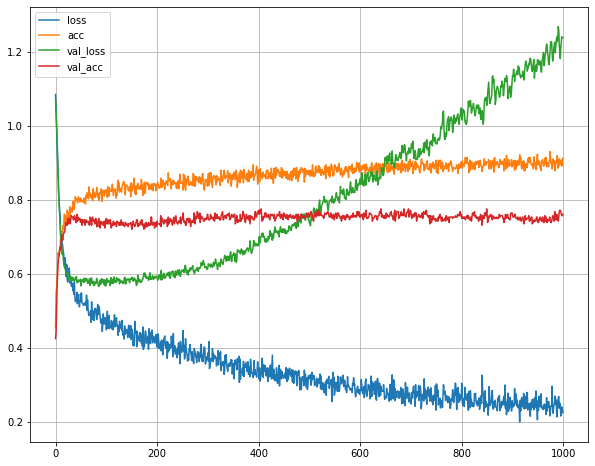

In [ ]:
dataset_F1toF4_B1toB4.Visualize()

## Problem 4
Use the data to predict the gender of the speaker. Try including the format bandwidths as features as well ("B1"-"B4").

In [ ]:
# We will be classifying gender. Extract the training and validation data

# train = rawtrain[rawtrain["Gender"].isin(Genders)]
# valid = rawvalid[rawvalid["Gender"].isin(Genders)]

genders = ["M", "F"]



In [ ]:
train

,SpeakerID,Gender,Phoneme,F1,F2,F3,F4,B1,B2,B3,B4
0,cjf0,F,h#,0.701982,2.125440,2.433528,3.530050,0.264459,0.326273,0.300301,0.410096
1,cjf0,F,q,0.340942,2.594934,2.788244,4.028250,0.282159,0.471724,0.310578,0.505835
2,cjf0,F,iy,0.487078,2.605132,3.093409,4.354061,0.174520,0.340025,0.232818,0.413965
3,cjf0,F,v,0.505536,2.034326,2.804329,4.130655,0.190478,0.307295,0.301741,0.370238
4,cjf0,F,ih,0.524527,2.055382,2.989248,4.480000,0.164466,0.312337,0.301859,0.362134
...,...,...,...,...,...,...,...,...,...,...,...
12586,dlr0,M,jh,0.317080,1.735735,2.685133,3.802678,0.295334,0.323007,0.320283,0.434864
12587,dlr0,M,ix,0.340064,1.564607,2.628403,3.798025,0.204859,0.315904,0.339310,0.439050
12588,dlr0,M,bcl,0.364364,1.065257,2.510217,3.680318,0.267162,0.336650,0.365627,0.426372
12589,dlr0,M,b,0.471267,0.900659,2.388870,3.701047,0.264954,0.309087,0.289148,0.428988


In [ ]:
class GenderModel:
    # initilize model based on given features
    def __init__(self, class_specifier, classes, features, name='model'):
        self.name = name
        self.classes = classes
        
        trainlabels = [genders.index(g) for g in rawtrain[class_specifier]]
        validlabels = [genders.index(g) for g in rawvalid[class_specifier]]

        # Extract features
        x_train_extracted = train[features]
        x_valid_extracted = valid[features]

        # Normalize to zero mean
        x_mean = np.mean(x_train_extracted)
        x_std = np.std(x_train_extracted)
        self.x_train = x_train_extracted - x_mean
        self.x_valid = x_valid_extracted - x_mean
        
        # Fix labels. The "to_categorical" call maps integer labels {n}
        # to a vector of length N (number of labels) with a one in position n
        self.y_train = keras.utils.to_categorical(trainlabels, len(classes))
        self.y_valid = keras.utils.to_categorical(validlabels, len(classes))

    # Visualize the training results
    def Visualize(self):
        if (self.history):
            plt.figure(figsize=(10, 8))
            plt.plot(self.history.history['loss'], label='loss')
            plt.plot(self.history.history['accuracy'], label='acc')
            plt.plot(self.history.history['val_loss'], label='val_loss')
            plt.plot(self.history.history['val_accuracy'], label='val_acc')
            plt.grid()
            plt.title(self.name)
            plt.legend()
            plt.show()
        else:
            print("No model intilized")

    def Validate(self):
        # Validation model
        score = self.model.evaluate(self.x_valid, self.y_valid, verbose=0)
        print('Validation loss:', score[0])
        print('Validation accuracy:', score[1])


gender_dataset_F1toF4_B1toB4 = GenderModel('Gender', genders, features_F1toF4_B1toB4, "gender_F1toF4_B1toB4")

In [ ]:
gender_dataset_F1toF4_B1toB4.y_train.shape

(12591, 2)

In [ ]:
# Create a model with a multi hidden layer
def Create_and_train_model(dataset):
    dataset.model = keras.Sequential([
        keras.layers.Dense(256, activation=tf.nn.relu, input_dim=dataset.x_train.shape[1]),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(64, activation=tf.nn.relu),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(len(dataset.classes), activation=tf.nn.softmax, name="pred", kernel_regularizer=keras.regularizers.l1(1e-5))
    ])

    dataset.model.summary()

    # Train the model
    dataset.model.compile(loss='categorical_crossentropy',
                        optimizer='adam',
                        metrics=['accuracy'])

    # Train the model
    dataset.history = dataset.model.fit(dataset.x_train, dataset.y_train, validation_data=(dataset.x_valid, dataset.y_valid),
                                    epochs=100, batch_size=32, verbose=True)
    dataset.model.save('models/model_'+dataset.name)

Create_and_train_model(gender_dataset_F1toF4_B1toB4)


Model: "sequential_41"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_74 (Dense)             (None, 256)               2304      
_________________________________________________________________
dropout_21 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_75 (Dense)             (None, 64)                16448     
_________________________________________________________________
dropout_22 (Dropout)         (None, 64)                0         
_________________________________________________________________
pred (Dense)                 (None, 2)                 130       
Total params: 18,882
Trainable params: 18,882
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
394/394 [==============================] - 1s 2ms/step - loss: 0.4561 - accuracy: 0.7949 - val_loss: 0.

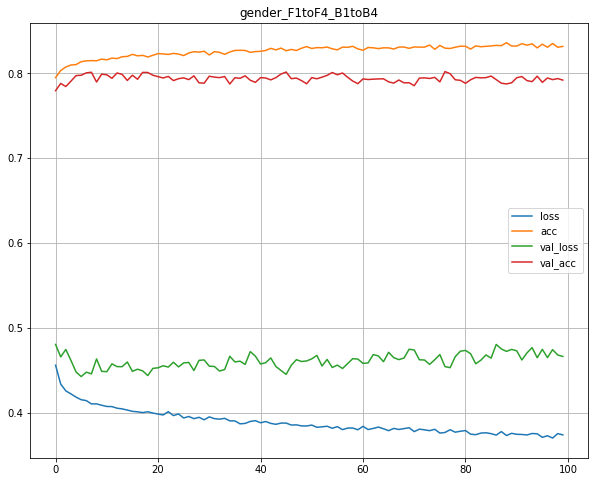

In [ ]:
gender_dataset_F1toF4_B1toB4.Visualize()

In [ ]:
gender_dataset_F1toF4_B1toB4.Validate()

Validation loss: 0.46635711193084717
Validation accuracy: 0.7919058799743652
